### IBD lengths

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
from numba import njit
import numpy as np
# importing sys
import itertools
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe

In [3]:
@njit()
def ibdscans(snps, pos, idx1, idx2):

    geno1 = snps[:, idx1]
    geno2 = snps[:, idx2]

    breakpoints = []

    # Scan right along genome, as long as two inds are not both homozygous but different
    for pos_idx in range(pos.shape[0]):
        
        gn1 = geno1[pos_idx]
        gn2 = geno2[pos_idx]        

        # Scan right along genome, as long as two inds are not both homozygous but different
        if (gn1[0] == gn1[1]) & (gn2[0] == gn2[1]) & ((gn1 != gn2).all()) & (-1 not in gn1 and -1 not in gn2):
            breakpoints.append(pos_idx)
    
    return(np.array(breakpoints))


In [4]:
metadata = pd.read_csv("../../config/metadata.tsv", sep="\t", index_col=0)

In [5]:
contig = '3L'
idx1 = 0
idx2 = 1

snps, pos = probe.loadZarrArrays(genotypePath=f"../../resources/snp_genotypes/all/1244-VO-GH-YAWSON-VMF00149/{contig}/calldata/GT/", 
                                        positionsPath=f"../../resources/snp_genotypes/all/sites/{contig}/variants/POS/",
                                        siteFilterPath=f"../../resources/site_filters/dt_20200416/gamb_colu/{contig}/variants/filter_pass/")

ac = snps.count_alleles()
seg = ac.is_segregating()
snps = snps.compress(seg, axis=0).compute().values
pos = pos[seg]

#### Scan whole chromosome

In [6]:
cohorts = probe.getCohorts(metadata, minPopSize=10)

In [7]:
cohorts['indices10'] = cohorts['indices'].apply(lambda x: np.sort(np.random.choice(x, 10, replace=False)))

In [8]:
ibd_sizes = []
n_breaks = []
xs = []
ys = []

idxs = np.concatenate(cohorts['indices10'])

for x,y in itertools.combinations(idxs, 2):

    breakpoints = ibdscans(snps, pos, x, y)
    breakpoints = pos[breakpoints]

    xs.append(x)
    ys.append(y)
    ibd_sizes.append(np.ediff1d(breakpoints))
    n_breaks.append(len(breakpoints))


In [11]:
df = pd.DataFrame({'idx1':xs, 'idx2':ys, 'hap_sizes': ibd_sizes, 'breaks':n_breaks})


In [14]:
df.shape

(11175, 4)

In [12]:
df.to_csv("../../results/ibd_distributions.tsv", sep="\t")

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
df['hap_sizes'][:1000].apply(max)

0       729782
1       294416
2       265786
3       363701
4       364688
        ...   
995    1120778
996     323997
997     138540
998     380277
999     364632
Name: hap_sizes, Length: 1000, dtype: int32

count     38496.000000
mean       1071.985973
std        6373.804988
min           1.000000
25%          32.000000
50%         240.000000
75%         996.000000
max      729782.000000
dtype: float64


/home/sanj/apps/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count     50439.000000
mean        830.767402
std        3493.383730
min           1.000000
25%          28.000000
50%         175.000000
75%         767.000000
max      294416.000000
dtype: float64


/home/sanj/apps/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count     50356.000000
mean        831.680614
std        3462.346705
min           1.000000
25%          28.000000
50%         185.000000
75%         797.000000
max      265786.000000
dtype: float64


/home/sanj/apps/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


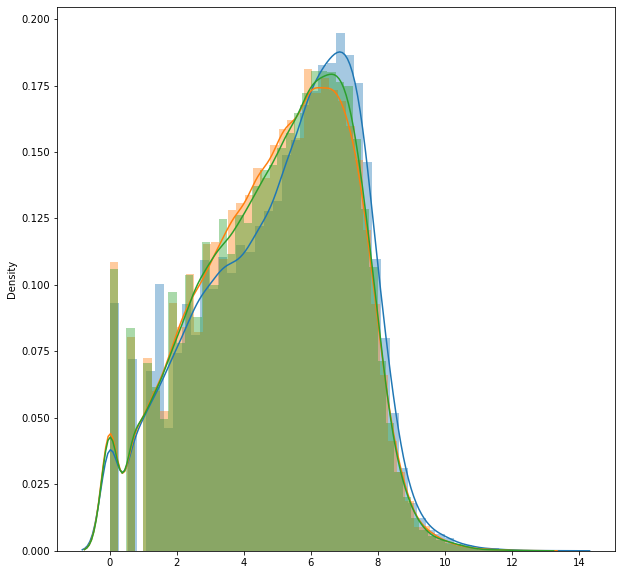

In [25]:
fig, ax = plt.subplots(1, figsize=[10,10])
for idx in range(3):
    a = pd.Series(df.loc[idx, 'hap_sizes']).describe()
    print(a)
    sns.distplot(np.log(df.loc[idx, 'hap_sizes']))

In [106]:
probe.log(f"Scanning {contig}, individuals - {idx1}, {idx2}")
breakpoints = ibdscans(snps, pos, idx1, idx2)
breakpoints = pos[breakpoints]
sizes = pd.Series(np.ediff1d(breakpoints))
probe.log("Done...")

Scanning 2L, individuals - 0, 1
Done...


In [ ]:
df = pd.DataFrame({'start':starts, 'end':ends, 'dblton_pos': dbltonpos})
df.to_csv(f"../../results/f2variants/f2HapLengths.{contig}.tsv", sep="\t")